In [25]:
import torch
from torch import nn

In [26]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
# !pip install requests
import requests
# requests.__version__
url='https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
url
from pathlib import Path
import tarfile
data_path=Path('dataset/')
image_path=data_path/'oxford_iiit_pet_images'
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    with open(data_path/"images.tar.gz",'wb') as f:
        request=requests.get(url,timeout=60)
        f.write(request.content)
    with tarfile.open(data_path/"images.tar.gz","r:gz") as tar:
        tar.extractall(image_path)

dataset\oxford_iiit_pet_images already exists


In [28]:
import os
def os_walk(dir_path):
    for dirpath,dirnames,filename in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filename)} images in {dirpath} ")




In [29]:
os_walk(image_path)

There are 0 directories and 0 images in dataset\oxford_iiit_pet_images 


In [30]:
train_path=image_path/'train'
test_path=image_path/'test'
train_path,test_path

(WindowsPath('dataset/oxford_iiit_pet_images/train'),
 WindowsPath('dataset/oxford_iiit_pet_images/test'))

In [31]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Dataset
class CustomDataSet(Dataset):
    def __init__(self,image_dir,transform=None):
        self.img_dir=image_dir
        self.transform=transform
        self.image_list=list(f for f in os.listdir(self.img_dir) if f.endswith((".jpg",".png")))
        self.classes=set(name.split("_")[0] for name in self.image_list)
        self.class_to_idx={cls_name:idx for idx,cls_name in enumerate(sorted(self.classes))}
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, index):
        img_names=self.image_list[index]
        img_path=os.path.join(self.img_dir,img_names)
        image=Image.open(img_path).convert('RGB')

        label_str=img_names.split('_')[0]
        label=self.class_to_idx[label_str]

        if self.transform:
            image=self.transform(image)
        return image,label
transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])

dataset=CustomDataSet(image_path/"images",transform=None)
classes=dataset.classes
# os.listdir(image_path)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset\\oxford_iiit_pet_images\\images'

In [ ]:
def create_balanced_split(dataset, train_ratio=0.8):
    class_indices = {}
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)
    
    train_indices = []
    test_indices = []
    
    # For each class, split proportionally
    for label, indices in class_indices.items():
        n_train = int(len(indices) * train_ratio)
        train_indices.extend(indices[:n_train])
        test_indices.extend(indices[n_train:])
    
    return train_indices, test_indices

In [ ]:
train_indices, test_indices = create_balanced_split(dataset, train_ratio=0.8)
print(f"Training set: {len(train_indices)} images")
print(f"Test set: {len(test_indices)} images")

# Create datasets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

Training set: 5911 images
Test set: 1479 images


In [ ]:
# now split into the training and the testing dataset 
from torch.utils.data import random_split
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size

train_dataset,test_dataset=random_split(dataset,[train_size,test_size])
len(train_dataset),len(test_dataset)
class TransformedDataset(Dataset):
    def __init__(self,dataset,transform=None,classes=None,class_to_idx=None):
        self.dataset=dataset
        self.transform=transform
        self.classes=classes
        self.class_to_idx=class_to_idx
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        image,label=self.dataset[idx]
        if self.transform:
            image=self.transform(image)
        return image,label
train_dataset=TransformedDataset(train_dataset,transform=transform,classes=dataset.classes,class_to_idx=dataset.class_to_idx)
test_dataset=TransformedDataset(test_dataset,transform=test_transform,classes=dataset.classes,class_to_idx=dataset.class_to_idx)


In [ ]:
# visualize
dataset[1]
# !pip install matplotlib
import random
import matplotlib.pyplot as plt 
def plot_dataset(dataset,classes=None,n=10):
    indices=random.sample(range(len(dataset)),n)
    plt.figure(figsize=(20,5))
    for i,idx in enumerate(indices):
        image_tensor,label=dataset[idx]
        img=image_tensor.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        if classes:
            plt.title(classes[label])
        else:
            plt.title(f"title: {label}")
    plt.show()




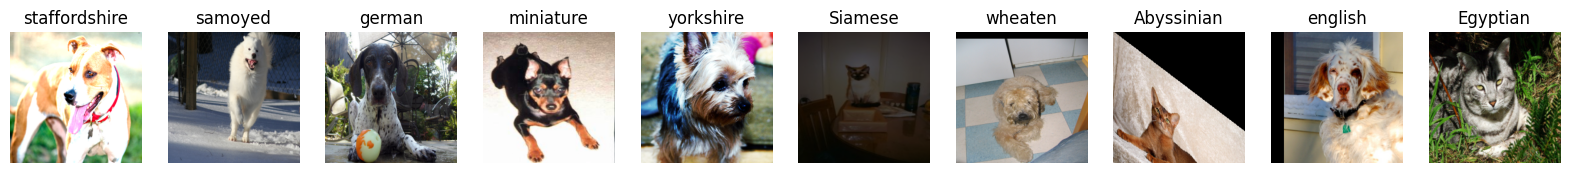

In [ ]:
plot_dataset(train_dataset,sorted(train_dataset.class_to_idx.keys()),10)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=0,pin_memory=True)
test_dataloader=DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=0,pin_memory=True)
# for image,label in train_dataloader:
#     print(image)

In [ ]:
# from torch import nn
# class FixedTinyVGG(nn.Module):
#     def __init__(self, input_channels, hidden_channels, output_channels):
#         super().__init__()
        
#         self.conv2d_0 = nn.Sequential(
#             nn.Conv2d(input_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.conv2d_1 = nn.Sequential(
#             nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_channels*2, hidden_channels*2, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.conv2d_2 = nn.Sequential(
#             nn.Conv2d(hidden_channels*2, hidden_channels*4, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_channels*4, hidden_channels*4, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(hidden_channels*4 * 28 * 28, 512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, output_channels)
#         )
    
#     def forward(self, x):
#         x = self.conv2d_0(x)
#         x = self.conv2d_1(x)
#         x = self.conv2d_2(x)
#         x = self.classifier(x)
#         return x

       


In [ ]:
# model_0=FixedTinyVGG(3,10,len(classes)).to(device)
# # for batch,(x,y) in enumerate(train_dataloader):
# #     x=x.to(device)
# #     y=y.to(device)
# #     y_pred=model_0(x)
# #     print(y_pred.softmax(dim=1).argmax(dim=1))
# #     print(y)

In [ ]:
def traning(model:torch.nn.Module,dataloader:torch.utils.data.Dataset,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer):
    model.train()
    train_loss,train_acc=0,0
    for batch,(x,y) in enumerate(dataloader): 
        x=x.to(device)
        y=y.to(device)
        y_pred_logits=model(x)
        loss=loss_fn(y_pred_logits,y)
        train_loss+=loss.item()
        y_pred=torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)
        train_acc+=(y_pred==y).sum().item()/len(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss=train_loss/len(dataloader)
    train_acc=train_acc/len(dataloader)
    return train_loss,train_acc


In [ ]:
# loss_fn=nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(params=model_0.parameters(),lr=0.00001)
# # traning(model_0,train_dataloader,loss_fn,optimizer)

In [ ]:
# adding dynamic and checkpoints
def save_checkpoint(model,optimizer,epoch,file_name='checkpoint.pth'):
    checkpoint={
        'epoch':epoch,
        'optimizer':optimizer.state_dict(),
        'model':model.state_dict()
    }
    torch.save(checkpoint,file_name)
    print(f"checkpoint saved at {file_name}")

def load_checkpoint(model,optimizer,file_name):
    if os.path.isfile(file_name):
        checkpoint=torch.load(file_name)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch=checkpoint['epoch']+1
        print(f"checkpoint loaded with epoch: {epoch}")
        return epoch
    else:
        print(f"no checkpoint to load")
        return 0



In [ ]:
# # !pip install tqdm
# import tqdm
# epochs=500
# start_epoch=load_checkpoint(model_0,optimizer,file_name='checkpoint.pth')
# for epoch in tqdm.tqdm(range(start_epoch,epochs)):
#     print(traning(model_0,train_dataloader,loss_fn,optimizer))
#     save_checkpoint(model_0,optimizer,epoch,file_name='checkpoint.pth')

In [ ]:
# import torchvision.models as models
# model_1=models.vgg16(pretrained=True)
# for param in model_1.features.parameters():
#     param.requires_grad = False
# num_features=model_1.classifier[6].in_features
# out_channels=len(classes)
# model_1.classifier[6]=torch.nn.Linear(num_features,out_channels)
# model_1=model_1.to(device)

In [ ]:
# # !pip install torchinfo
# import torchinfo
# from torchinfo import summary
# summary(model_1,input_size=(1,3,224,224))


In [ ]:
# from torch.cuda.amp import GradScaler, autocast
# import torch.optim as optim
# from torchvision import models

# # Assuming model_1 is VGG
# # model_1 = models.vgg16(pretrained=True).to(device)  # Or your custom VGG
# optimizer = optim.Adam(model_1.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# scaler = GradScaler()
# epochs=100
# start_epoch=load_checkpoint(model_1,optimizer,file_name="checkpoint_VGG.pth")
# prev_acc=0.0
# for epoch in range(start_epoch,epochs):
#     model_1.train()
#     running_loss = 0.0
#     running_acc=0.0
#     for inputs, labels in train_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         with autocast():
#             outputs = model_1(inputs)
#             loss = criterion(outputs, labels)
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
#         running_loss += loss.item()
#         # running_acc += (outputs.argmax(dim=1) == labels).sum().item()
#         y_pred=torch.argmax(torch.softmax(outputs,dim=1),dim=1)
#         running_acc+=(y_pred==labels).sum().item()
#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {running_acc/len(train_dataloader):.4f}  Accuracy Increase: {running_acc/len(train_dataloader)-prev_acc:.4f}")
#     prev_acc=running_acc/len(train_dataset)
#     save_checkpoint(model_1,optimizer,epoch,file_name="checkpoint_VGG.pth")

In [ ]:
def eval(model,test_dataloader,loss_fn,test_dataset):
    model.eval()
    with torch.inference_mode():
        test_acc=0
        test_loss=0
        for batch,(x,y) in enumerate(test_dataloader):
            x=x.to(device)
            y=y.to(device)
            y_pred_logits=model(x)
            loss=loss_fn(y_pred_logits,y)
            y_pred=torch.argmax(y_pred_logits,dim=1)
            test_loss+=loss.item()
            test_acc+=(y_pred==y).sum().item()
        print(f"Test loss: {test_loss/len(test_dataset)}     Test Accuracy: {test_acc/len(test_dataset)}")





In [ ]:
# eval(model_1,test_dataloader,criterion)

In [ ]:
import torchvision.models as models
model_2=models.efficientnet_b0(pretrained=True)
for param in model_2.features.parameters():
    param.requires_grad = False
num_features=model_2.classifier[1].in_features
out_channels=len(classes)
model_2.classifier[1]=torch.nn.Linear(num_features,out_channels)
model_2=model_2.to(device)

c:\Users\DELL\miniconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\miniconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
start_epoch=load_checkpoint(model_2,optimizer,file_name="checkpoint_Efficent_B0.pth")

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
from torchvision import models

# Assuming model_1 is VGG
# model_1 = models.vgg16(pretrained=True).to(device)  # Or your custom VGG
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
epochs=100
start_epoch=load_checkpoint(model_2,optimizer,file_name="checkpoint_Efficent_B0.pth")
prev_acc=0.0
for epoch in range(start_epoch,epochs):
    model_2.train()
    running_loss = 0.0
    running_acc=0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model_2(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        # running_acc += (outputs.argmax(dim=1) == labels).sum().item()
        y_pred=torch.argmax(torch.softmax(outputs,dim=1),dim=1)
        running_acc+=(y_pred==labels).sum().item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataset):.4f}, Accuracy: {running_acc/len(train_dataset):.4f}  Accuracy Increase: {running_acc/len(train_dataset)-prev_acc:.4f}")
    prev_acc=running_acc/len(train_dataset)
    save_checkpoint(model_2,optimizer,epoch,file_name="checkpoint_Efficent_B0.pth")

C:\Users\DELL\AppData\Local\Temp\ipykernel_1744\1281227325.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\DELL\AppData\Local\Temp\ipykernel_1744\3140095717.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

checkpoint loaded with epoch: 63


C:\Users\DELL\AppData\Local\Temp\ipykernel_1744\1281227325.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 64, Loss: 0.0068, Accuracy: 0.8694  Accuracy Increase: 0.8694
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 65, Loss: 0.0063, Accuracy: 0.8784  Accuracy Increase: 0.0090
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 66, Loss: 0.0066, Accuracy: 0.8711  Accuracy Increase: -0.0073
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 67, Loss: 0.0060, Accuracy: 0.8824  Accuracy Increase: 0.0113
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 68, Loss: 0.0059, Accuracy: 0.8904  Accuracy Increase: 0.0079
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 69, Loss: 0.0061, Accuracy: 0.8838  Accuracy Increase: -0.0066
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 70, Loss: 0.0058, Accuracy: 0.8892  Accuracy Increase: 0.0054
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 71, Loss: 0.0059, Accuracy: 0.8850  Accuracy Increase: -0.0042
checkpoint saved at checkpoint_Efficent_B0.pth
Epoch 72, Loss: 0.0060, Accuracy: 0.8806  Accuracy Increase: -0.0044
checkpoi

In [ ]:
eval(model_2,test_dataloader,criterion,test_dataset)

Test loss: 0.0047426158171626     Test Accuracy: 0.9005412719891746


In [ ]:
# try with the random samples
def plot_samples_pred(model,dataset,n,device,classes):
    model=model.to(device)
    model.eval()
    indices=random.sample(range(len(dataset)),n)
    plt.figure(figsize=(20,15))
    to_tensor=transforms.ToTensor()
    for i,idx in enumerate(indices):
        image_pil,label=dataset[idx]
        image_tensor=to_tensor(image_pil)
        img=image_tensor.permute(1,2,0)
        image_tensor=image_tensor.unsqueeze(0).to(device)

        with torch.inference_mode():
            y_pred=model(image_tensor)
            y_pred=torch.argmax(y_pred,dim=1)
        plt.subplot(4,3,i+1)
        plt.imshow(img)
        plt.axis('off')
        prediction=classes[y_pred]
        title_color = 'green' if y_pred == label else 'red'
        if prediction:
            plt.title(f"Actual :{classes[label]}  Predicted :{prediction}",color=title_color)
        else:
            plt.title(f"Actual :{classes[label]}  Predicted :{y_pred}",color=title_color)
    plt.show()





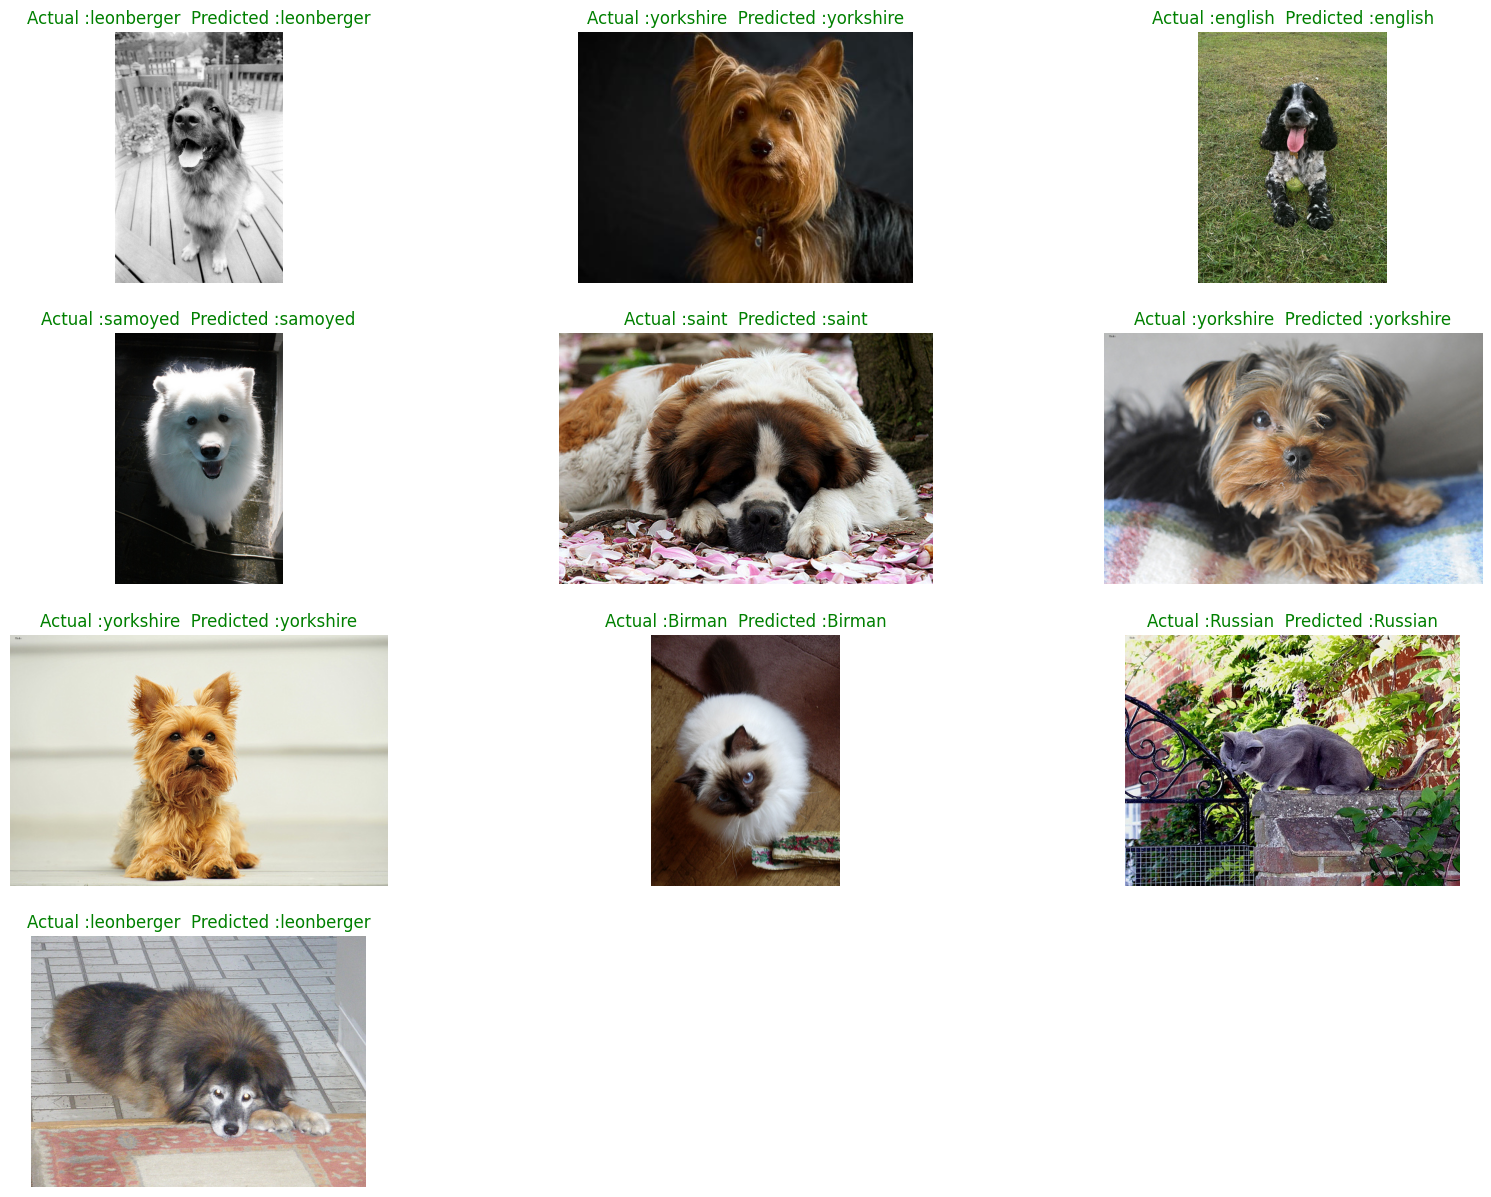

In [ ]:
classes_list = sorted(list(classes))
plot_samples_pred(model_2,dataset,10,device,classes_list)

In [ ]:
classes

{'Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British',
 'Egyptian',
 'Maine',
 'Persian',
 'Ragdoll',
 'Russian',
 'Siamese',
 'Sphynx',
 'american',
 'basset',
 'beagle',
 'boxer',
 'chihuahua',
 'english',
 'german',
 'great',
 'havanese',
 'japanese',
 'keeshond',
 'leonberger',
 'miniature',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint',
 'samoyed',
 'scottish',
 'shiba',
 'staffordshire',
 'wheaten',
 'yorkshire'}

In [ ]:
from torchinfo import summary
summary(model_2,input_size=(1,3,224,224))

NameError: name 'model_2' is not defined